In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import copy
from utils import merge_image_superpixels

In [2]:
image_names = ["2007_000068", "2007_000121", "2007_000123"]
voc_ext = ".jpg"
gt_ext = ".png"

voc_dir = "data/voc12/"
gt_dir = "data/gt/"

images = []
gt_images = []

images_gray = []

for name in image_names:
    img = cv2.imread(voc_dir + name + voc_ext)
    gt = cv2.imread(gt_dir + name + gt_ext)
   
    images.append(img)
    gt_images.append(gt)

    images_gray.append(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))

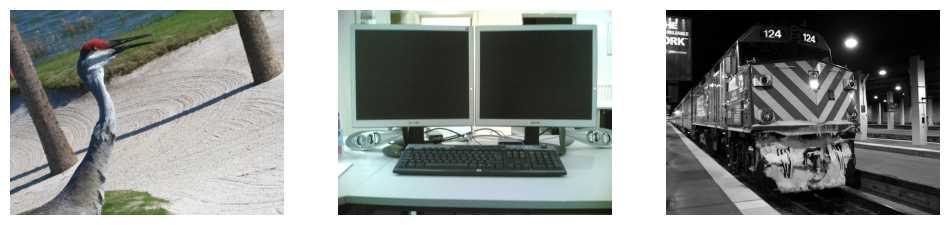

In [3]:
fig = plt.figure(figsize=(12, 4))

rows = 1
cols = 3

for i, img in enumerate(images):
    fig.add_subplot(rows, cols, i+1)
    plt.axis("off")
    plt.imshow(img[:,:,::-1])

## Superpixels

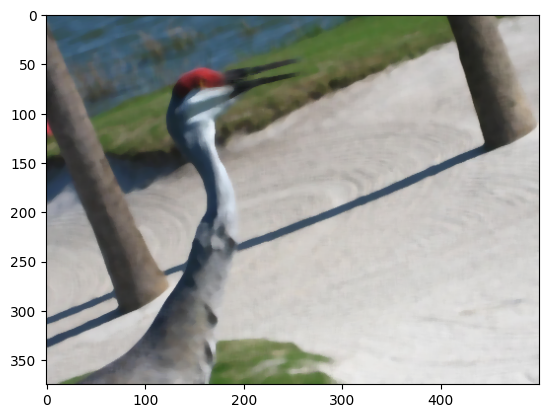

In [4]:
median_blurred = cv2.medianBlur(images[0], 7)
plt.imshow(median_blurred[:,:,::-1])

In [217]:
use_blurred = True
lab_img = cv2.cvtColor(images[0], cv2.COLOR_BGR2Lab)

if use_blurred:
    lab_img = cv2.cvtColor(median_blurred, cv2.COLOR_BGR2Lab)

superpixels_slic = cv2.ximgproc.createSuperpixelSLIC(lab_img, algorithm=cv2.ximgproc.SLIC, region_size=16)
superpixels_slic.iterate()
superpixels_slic_mask = superpixels_slic.getLabelContourMask()
print(superpixels_slic.getNumberOfSuperpixels())

height, width, channels = lab_img.shape[0], lab_img.shape[1], lab_img.shape[2]

superpixels_seeds = cv2.ximgproc.createSuperpixelSEEDS(width, height, channels,2000, 5)
superpixels_seeds.iterate(lab_img)
superpixels_seeds_mask = superpixels_seeds.getLabelContourMask()
print(superpixels_seeds.getNumberOfSuperpixels())

superpixels_lsc = cv2.ximgproc.createSuperpixelLSC(lab_img, region_size=16)
superpixels_lsc.iterate()
superpixels_lsc_mask = superpixels_lsc.getLabelContourMask()
print(superpixels_lsc.getNumberOfSuperpixels())

713
713
713


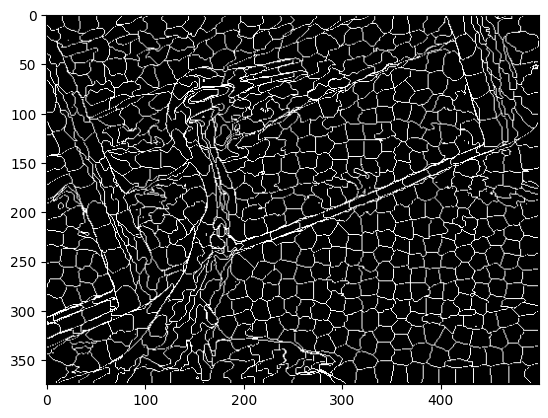

In [218]:
plt.imshow(superpixels_slic_mask, cmap="gray")

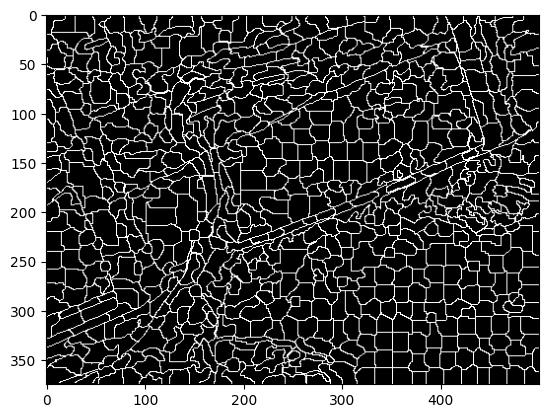

In [219]:
plt.imshow(superpixels_seeds_mask, cmap="gray")

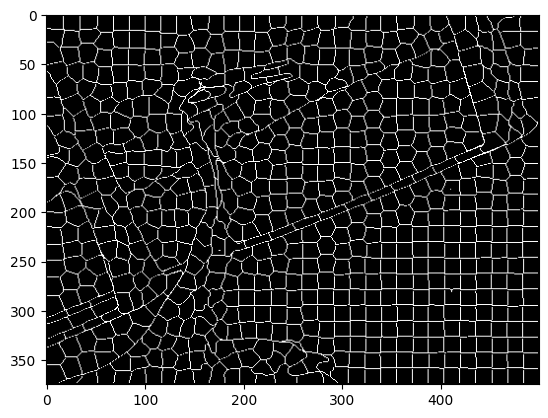

In [220]:
plt.imshow(superpixels_lsc_mask, cmap="gray")

In [221]:
superpixel_contour_img = merge_image_superpixels(images[0], superpixels_lsc_mask, [0,255,0])

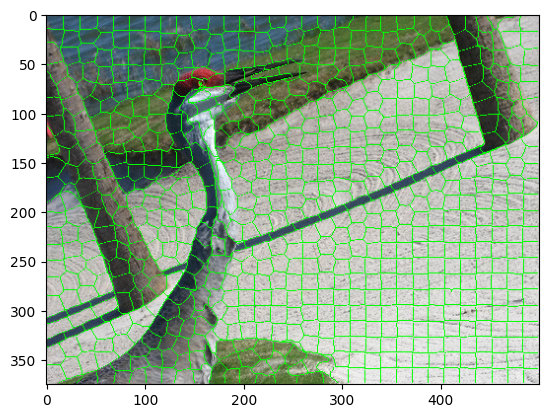

In [222]:
plt.imshow(superpixel_contour_img[:,:,::-1])

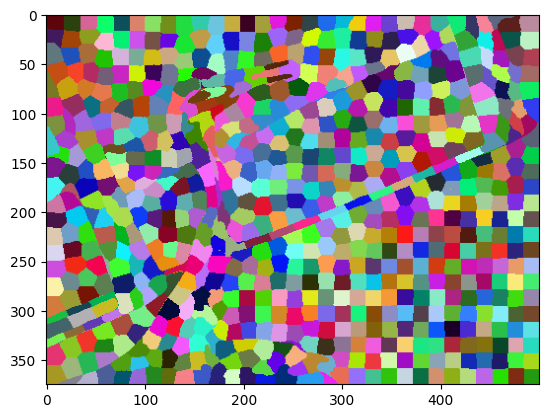

In [223]:
superpixel_labels = superpixels_lsc.getLabels()

visualization_superpixels = np.zeros((superpixel_labels.shape[0],superpixel_labels.shape[1],3), np.uint8)
random_colors = []

for i in np.unique(superpixel_labels):
    random_colors.append(np.random.randint(0,256,(3,)))
for i in range(superpixel_labels.shape[0]):
    for j in range(superpixel_labels.shape[1]):
        visualization_superpixels[i, j] = random_colors[superpixel_labels[i, j]]

plt.imshow(visualization_superpixels)

In [238]:
mean_img = np.zeros(lab_img.shape, np.uint8)
masks = []

for i in np.unique(superpixel_labels):
    mask = np.where(superpixel_labels == i, 1, 0).astype(np.uint8)
    mean = cv2.mean(lab_img, mask=mask)
    mean_img[mask==1] = mean[:3]
    masks.append(mask)

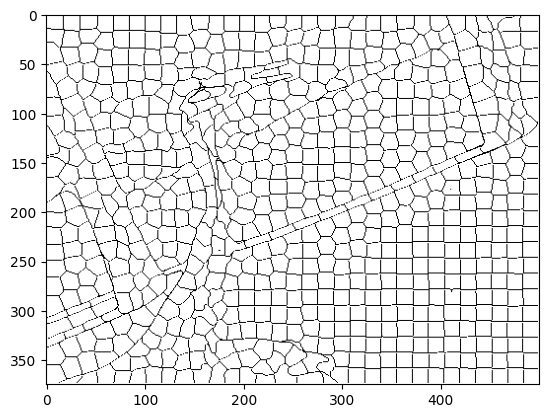

In [242]:
plt.imshow(~superpixels_lsc_mask, cmap="gray")

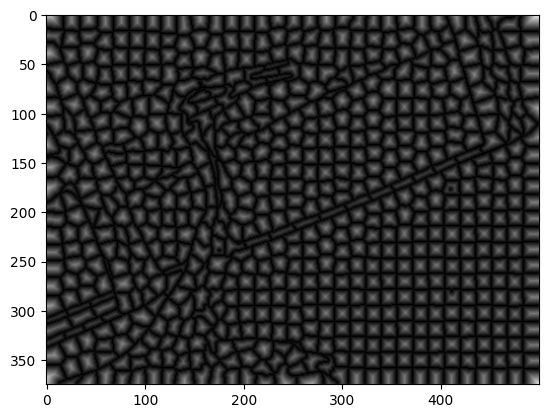

In [246]:
dist_trans = cv2.distanceTransform(~superpixels_lsc_mask, cv2.DIST_L2, 5)
plt.imshow(dist_trans, cmap="gray")

In [268]:
local_maxima = np.zeros(superpixels_lsc_mask.shape, np.uint8)

for mask in masks:
    masked = mask * dist_trans
    local_maximum = np.argwhere(masked == np.max(masked))[0]
    local_maxima[local_maximum[0], local_maximum[1]] = 1

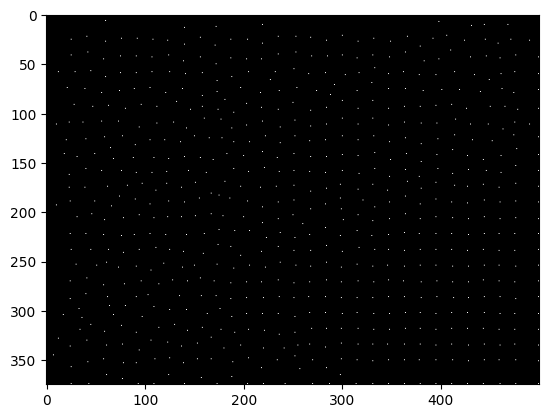

In [269]:
plt.imshow(local_maxima, cmap="gray")

In [ ]:
# kNN?

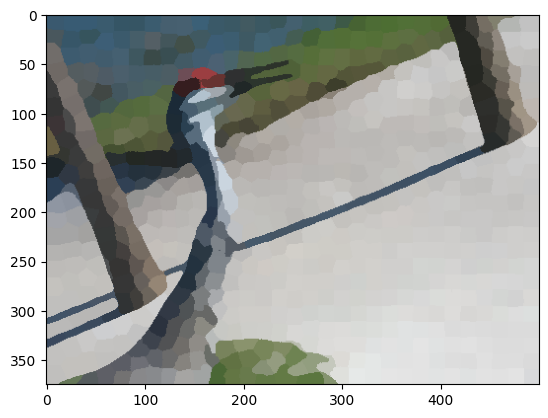

In [225]:
lab_2_bgr = cv2.cvtColor(mean_img, cv2.COLOR_Lab2BGR)
plt.imshow(lab_2_bgr[:,:,::-1])

## Semi-supervised mask creation

In [226]:
# click on superpixels

# idea: priemerna hodnota kazdeho superpixelu -> "kachlickovy" obrazok -> potom floodfill
# potom grabcut

# alebo naklikanie hranicnych superpixelov - tie budu possible foreground a vnutri budu sure foreground

In [88]:
x_click = 0
y_click = 0

def mouse_callback(event, x, y, flags, param):
    global x_click, y_click
    if event == cv2.EVENT_LBUTTONDOWN:
        print(f"Left button clicked at ({x}, {y})")
        x_click = x
        y_click = y

In [167]:
cv2.imshow("Image", lab_2_bgr)
cv2.setMouseCallback('Image', mouse_callback)
cv2.waitKey(0)
cv2.destroyAllWindows()

Left button clicked at (159, 250)


In [194]:
mask_at_click = masks[0]

for i, mask in enumerate(masks):
    if mask[y_click, x_click] == 1:
        mask_at_click = mask
        print(f"Mask number {i+1}")

Mask number 107
